In [19]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from sklearn.model_selection import GridSearchCV, KFold, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor

In [2]:
df = pd.read_csv('Data\concrete.csv', sep=';')
df.head()

,Cement,Blast_Furnace_Slag,Fly_Ash,Water,Superplasticizer,Coarse_Aggregate,Fine_Aggregate,Age,Concrete_Compressive_Strength
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.99
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.89
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.27
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.05
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.30


EXPLORATORY ANALYSIS

In [3]:
df.describe()

,Cement,Blast_Furnace_Slag,Fly_Ash,Water,Superplasticizer,Coarse_Aggregate,Fine_Aggregate,Age,Concrete_Compressive_Strength
count,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000
mean,281.167864,73.895825,54.188350,181.567282,6.204660,972.918932,773.580485,45.662136,35.817961
std,104.506364,86.279342,63.997004,21.354219,5.973841,77.753954,80.175980,63.169912,16.705742
min,102.000000,0.000000,0.000000,121.800000,0.000000,801.000000,594.000000,1.000000,2.330000
25%,192.375000,0.000000,0.000000,164.900000,0.000000,932.000000,730.950000,7.000000,23.710000
50%,272.900000,22.000000,0.000000,185.000000,6.400000,968.000000,779.500000,28.000000,34.445000
75%,350.000000,142.950000,118.300000,192.000000,10.200000,1029.400000,824.000000,56.000000,46.135000
max,540.000000,359.400000,200.100000,247.000000,32.200000,1145.000000,992.600000,365.000000,82.600000


Text(0.5, 1.0, 'Correlation Matrix')

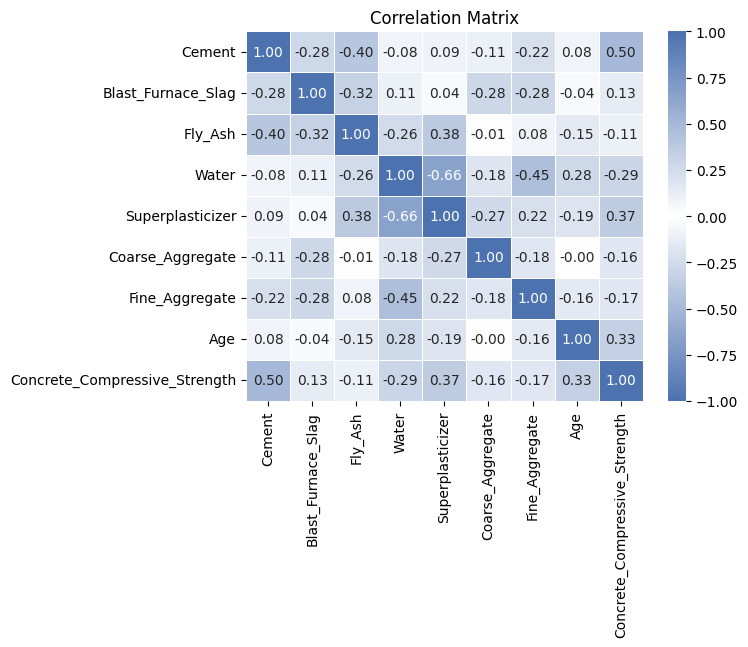

In [4]:
correlation_matrix = df.corr()
cmap = LinearSegmentedColormap.from_list('custom_blue_white_blue', [sns.color_palette('deep')[0], 'white', sns.color_palette('deep')[0]])
sns.heatmap(correlation_matrix, vmin=-1, vmax=1, cmap=cmap, annot=True, fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix")

Text(0.5, 1.02, 'Correlogram')

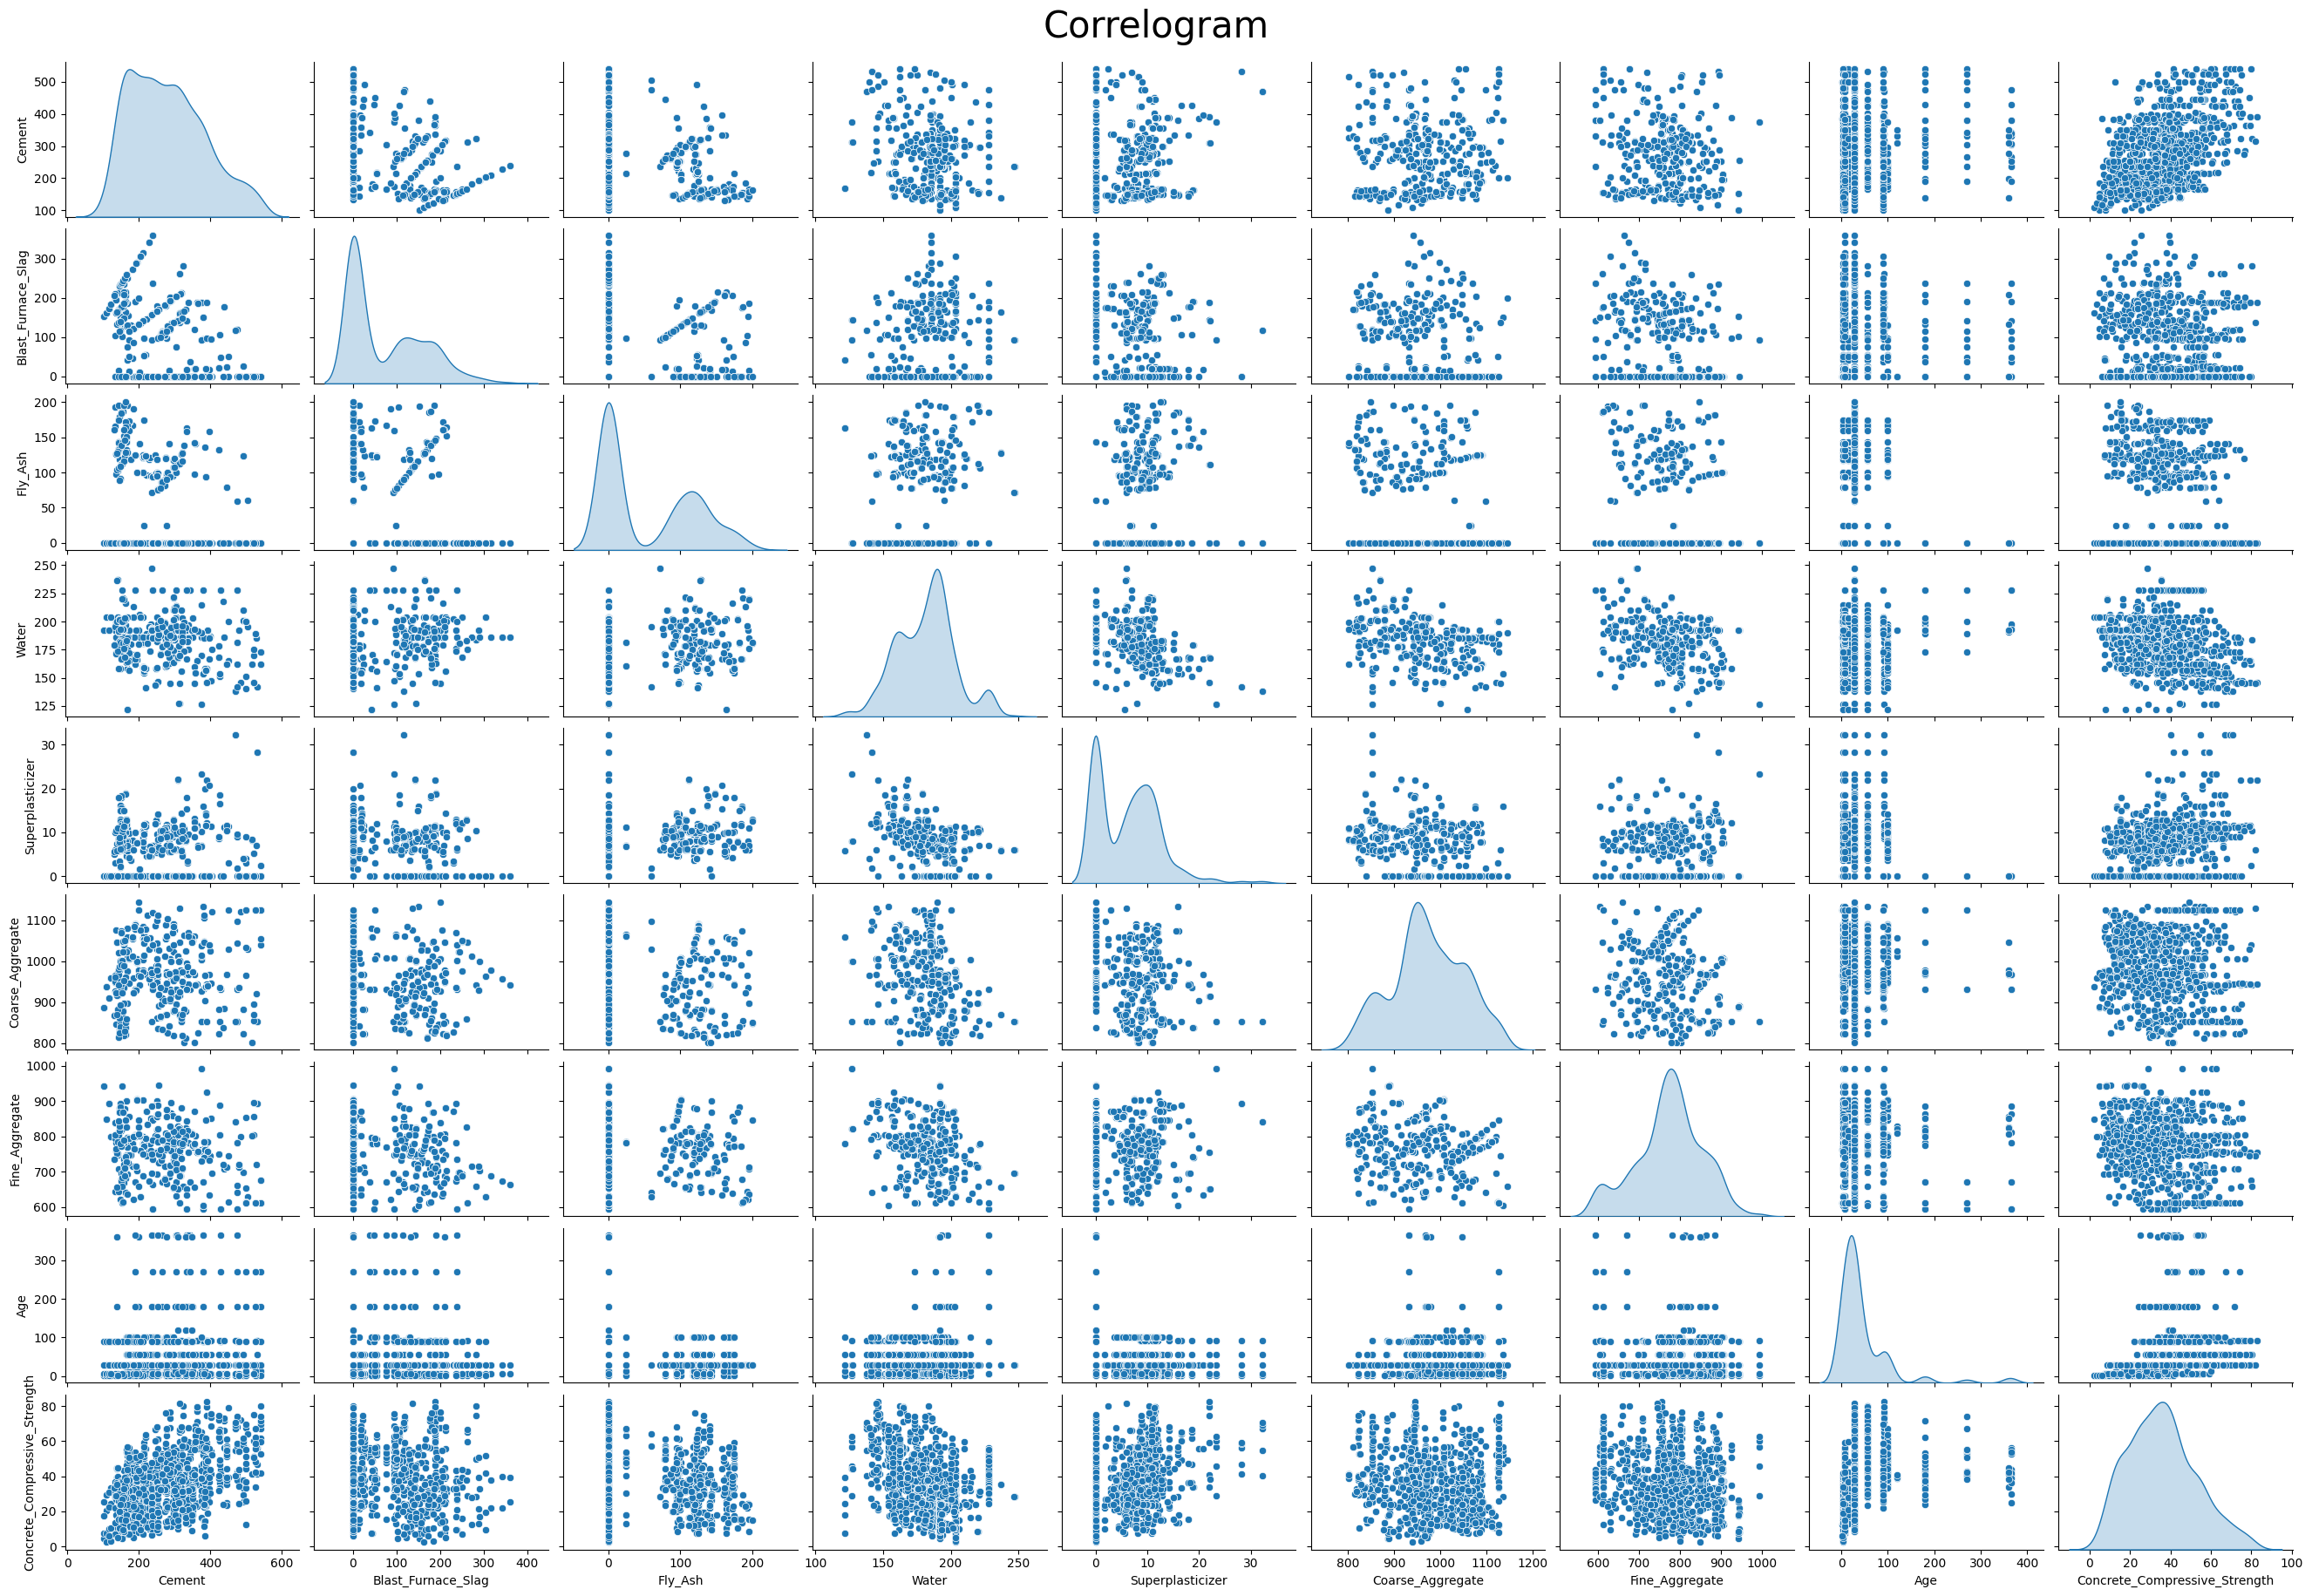

In [5]:
sns.pairplot(df, diag_kind='kde', markers='o', height=2, aspect=1.5)
plt.suptitle('Correlogram', y=1.02, fontsize=30)

MODEL

In [20]:
X = df.drop('Concrete_Compressive_Strength', axis=1)
y = df['Concrete_Compressive_Strength']

In [21]:
random_state = 64
nfold = 5

In [22]:
# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)

In [23]:
# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [24]:
# Define the neural network model
def build_model(hidden_layer1_size=64, hidden_layer2_size=32, activation='relu', loss='mean_squared_error'):
    model = Sequential()
    model.add(Dense(hidden_layer1_size, input_dim=X_train_scaled.shape[1], activation=activation))
    model.add(Dense(hidden_layer2_size, activation=activation))
    model.add(Dense(1, activation='linear'))
    model.compile(optimizer='adam', loss=loss, metrics=['mae'])
    return model

In [25]:
# Create a KerasRegressor wrapper for use with scikit-learn
regressor = KerasRegressor(build_fn=build_model, epochs=50, batch_size=32, verbose=0)

C:\Users\Davide\AppData\Local\Temp\ipykernel_15108\3489254892.py:2: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  regressor = KerasRegressor(build_fn=build_model, epochs=50, batch_size=32, verbose=0)


In [26]:
# Define hyperparameters for grid search
param_grid = {
    'hidden_layer1_size': [32, 64, 128],
    'hidden_layer2_size': [16, 32, 64],
    'activation': ['relu', 'tanh', 'sigmoid'],
    'loss': ['mean_squared_error', 'mean_absolute_error'],
    'epochs': [50],  # You can add more values for epochs if needed
    'batch_size': [32]  # You can add more values for batch_size if needed
}

In [27]:
# Perform k-fold cross-validation
kf = KFold(n_splits=nfold, shuffle=True, random_state=random_state)

In [28]:
grid_search = GridSearchCV(estimator=regressor, param_grid=param_grid, scoring='neg_mean_absolute_error', cv=kf)
grid_result = grid_search.fit(X_train_scaled, y_train)

In [33]:
pd.set_option('display.max_colwidth', None)
cv_results = pd.DataFrame(grid_result.cv_results_)
cv_results[['params', 'mean_test_score', 'std_test_score', 'rank_test_score']].sort_values(by='rank_test_score')

,params,mean_test_score,std_test_score,rank_test_score
35,"{'activation': 'tanh', 'batch_size': 32, 'epochs': 50, 'hidden_layer1_size': 128, 'hidden_layer2_size': 64, 'loss': 'mean_absolute_error'}",-6.122795,0.379538,1
17,"{'activation': 'relu', 'batch_size': 32, 'epochs': 50, 'hidden_layer1_size': 128, 'hidden_layer2_size': 64, 'loss': 'mean_absolute_error'}",-6.199250,0.629800,2
29,"{'activation': 'tanh', 'batch_size': 32, 'epochs': 50, 'hidden_layer1_size': 64, 'hidden_layer2_size': 64, 'loss': 'mean_absolute_error'}",-6.288829,0.382625,3
34,"{'activation': 'tanh', 'batch_size': 32, 'epochs': 50, 'hidden_layer1_size': 128, 'hidden_layer2_size': 64, 'loss': 'mean_squared_error'}",-6.410116,0.524028,4
23,"{'activation': 'tanh', 'batch_size': 32, 'epochs': 50, 'hidden_layer1_size': 32, 'hidden_layer2_size': 64, 'loss': 'mean_absolute_error'}",-6.538837,0.614415,5
13,"{'activation': 'relu', 'batch_size': 32, 'epochs': 50, 'hidden_layer1_size': 128, 'hidden_layer2_size': 16, 'loss': 'mean_absolute_error'}",-6.702520,0.419761,6
28,"{'activation': 'tanh', 'batch_size': 32, 'epochs': 50, 'hidden_layer1_size': 64, 'hidden_layer2_size': 64, 'loss': 'mean_squared_error'}",-6.705678,0.482478,7
15,"{'activation': 'relu', 'batch_size': 32, 'epochs': 50, 'hidden_layer1_size': 128, 'hidden_layer2_size': 32, 'loss': 'mean_absolute_error'}",-6.733268,0.469345,8
22,"{'activation': 'tanh', 'batch_size': 32, 'epochs': 50, 'hidden_layer1_size': 32, 'hidden_layer2_size': 64, 'loss': 'mean_squared_error'}",-6.935448,0.459002,9
16,"{'activation': 'relu', 'batch_size': 32, 'epochs': 50, 'hidden_layer1_size': 128, 'hidden_layer2_size': 64, 'loss': 'mean_squared_error'}",-6.946000,0.485256,10


In [29]:
# Print the best parameters and corresponding mean test score
print(f'Best Parameters: {grid_result.best_params_}')
print(f'Best Mean Absolute Error: {-grid_result.best_score_}')

Best Parameters: {'activation': 'tanh', 'batch_size': 32, 'epochs': 50, 'hidden_layer1_size': 128, 'hidden_layer2_size': 64, 'loss': 'mean_absolute_error'}
Best Mean Absolute Error: 6.12279497136252


In [30]:
# Evaluate the best model on the test set
best_model = grid_result.best_estimator_
final_predictions = best_model.predict(X_test_scaled)
final_mae = mean_absolute_error(y_test, final_predictions)
print(f'Mean Absolute Error (Test Set): {final_mae}')

Mean Absolute Error (Test Set): 5.825606015260936
